## MNIST with convolutional neural networks

MNIST is a classic handwritten digits dataset consisting of 28x28 pixel grayscale images of handwritten digits 0 through 9, split into 55k images for training and 10k images for testing.
Here we follow the recipe from the [TensorFlow tutorial](https://www.tensorflow.org/get_started/mnist/pros) very closely, and reproduce their results.

In [1]:
# The command "%matplotlib inline" is a "Jupyter magic" which loads a Jupyter
# extension that lets matplotlib render its outputs directly into the Notebook.
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

# Here we can specify which device to use if we e.g. want to do CPU only,
# or want to avoid conflicting with a miner running on another GPU.
DEVICE_TO_USE = "/gpu:0"

In [2]:
# MNIST is so iconic that TensorFlow literally comes with the dataset built-in.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Test images array shape:     (10000, 784)
Training images array shape: (55000, 784)


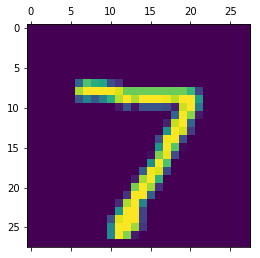

In [3]:
# Each MNIST image is 28x28, but has been flattened into a single vector of length 784.
# Thus, the test data is stored in a big numpy array of shape (10000, 784),
# and the training data is stored of shape (55000, 784).
print "Test images array shape:    ", mnist.test.images.shape
print "Training images array shape:", mnist.train.images.shape

# We can pull out a single image of shape (784,), and then reshape it to (28, 28) to get an image.
image = mnist.test.images[0].reshape((28, 28))

# Matplotlib has a convenient array plotting function that interprets the array as a heatmap.
plt.matshow(image)

In [4]:
# Test and training labels are stored in a "one-hot" representation as a vector of length 10.
# A label vector has a 1 in the position corresponding to the digit's value, and 0s elsewhere.
print "Test labels array shape:", mnist.test.labels.shape

# Observe that the test label for the first image has a 1 in position 7 indicating a seven.
print "Test label for the first test image:", mnist.test.labels[0]

Test labels array shape: (10000, 10)
Test label for the first test image: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


## Build a convolutional neural network.

We now build a CNN to classify these 28x28 images. For more info, see the TensorFlow tutorial linked above.

In [5]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# By nesting our code within this with block we force which GPU is used. (This is optional.)
with tf.device(DEVICE_TO_USE):
    input_placeholder = tf.placeholder(tf.float32, shape=[None, 784])
    desired_output_placeholder = tf.placeholder(tf.float32, shape=[None, 10])

    # Reshape the input from being flattened vectors into 2D arrays.
    x_image = tf.reshape(input_placeholder, [-1, 28, 28, 1])
    
    # Layer 1: Convolutional, 32 filters. (conv, then bias, then ReLU, then max pooling)
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    # Layer 2: Convolutional, 64 filters. (conv, then bias, then ReLU, then max pooling)
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    # Layer 3: Fully connected. (reshape, then mult, then bias, then ReLU)
    # Note that after two rounds of max pooling the image is only 7x7. Thus, when we reshape
    # the 2D data back into a flat vector it is 7*7*64 long (because 64 conv filters).
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Layer 3.5: Dropout (regularization). This is almost completely unnecessary.
    # Here we create a scalar valued keep_prob placeholder to feed in whether or not we're training.
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Layer 4: Fully connected. (mult, then bias, no ReLU)
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    # Finally, we need to define what we're optimizing.
    # We're averaging (tf.reduce_mean) the cross-entropy (tf.nn.softmax_cross_entropy_with_logits).
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels=desired_output_placeholder,
            logits=y_conv
        )
    )
    # Use a built-in optimizer with learning rate 1e-4, set to minimize cross_entropy.
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    # Define a node that computes if the mode of our prediction is in the correct spot.
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(desired_output_placeholder, 1))
    # Define a node that casts this bool-valued tensor to {0.0, 1.0}, and then averages it.
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Make an interactive session (throwing away all old data).
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [6]:
def print_accuracy():
    test_accuracy = accuracy.eval(feed_dict={
        input_placeholder: mnist.test.images,
        desired_output_placeholder: mnist.test.labels,
        keep_prob: 1.0,
    })
    print "Test-set accuracy %6.2f%%" % (test_accuracy * 100,)

for training_step in xrange(5000):
    # Get a mini-batch that consists of (fifty images, fifty labels).
    # Thus, batch[0] has shape (50, 784) and batch[1] has shape (50, 10).
    batch = mnist.train.next_batch(50)

    # Print accuracy periodically.
    if training_step % 250 == 0:
        print "Step %4i:" % (training_step,),
        print_accuracy()

    # Do a training step on the batch!
    train_step.run(feed_dict={
        input_placeholder: batch[0],
        desired_output_placeholder: batch[1],
        keep_prob: 0.5,
    })

print "Final result:",
print_accuracy()

Step    0: Test-set accuracy   9.23%
Step  250: Test-set accuracy  92.17%
Step  500: Test-set accuracy  95.00%
Step  750: Test-set accuracy  96.07%
Step 1000: Test-set accuracy  96.30%
Step 1250: Test-set accuracy  96.88%
Step 1500: Test-set accuracy  97.23%
Step 1750: Test-set accuracy  97.65%
Step 2000: Test-set accuracy  97.65%
Step 2250: Test-set accuracy  97.84%
Step 2500: Test-set accuracy  97.78%
Step 2750: Test-set accuracy  98.19%
Step 3000: Test-set accuracy  98.18%
Step 3250: Test-set accuracy  98.38%
Step 3500: Test-set accuracy  98.21%
Step 3750: Test-set accuracy  98.12%
Step 4000: Test-set accuracy  98.45%
Step 4250: Test-set accuracy  98.52%
Step 4500: Test-set accuracy  98.50%
Step 4750: Test-set accuracy  98.66%
Final result: Test-set accuracy  98.79%


## Model usage.

We trained our model to minimize softmax cross-entropy between its 10 dimensional output in the node `y_conv` and the one-hot label vectors from the training set.

As a result, we can now evaluate the `y_conv` node on new images to get classification logits out.
To convert these logits to a probability distribution we need to softmax them, specifically where $l_i$ is the array of logits, the probability that we classify the digit as $i$ is:

$$ p(i) = \frac{\operatorname{exp}(l_i)}{\sum_{k=0}^9 \operatorname{exp}(l_k)} $$

This is the softmax function. The `softmax` function below is just a more numerically stable way of writing this.

In [7]:
def classify(image):
    def softmax(logits):
        """Somewhat numerically stable softmax routine."""
        e_x = np.exp(logits - np.max(logits))
        return e_x / e_x.sum()
    # Feed in just the one image.
    logits = y_conv.eval(feed_dict={input_placeholder: [image], keep_prob: 1.0})
    # Softmax the logits to get a normalized probability distribution out.
    distribution = softmax(logits)
    return distribution

We now pull out three random images from the test set and look at the distribution of answers our classifier gives.
Because the classifier is almost always almost completely certain about its result, we raise the distribution to the 0.1 power to amplify the low-probability guesses, purely for rendering purposes to make the (slight) uncertainty more visible.
Rerun the cell to see more examples.

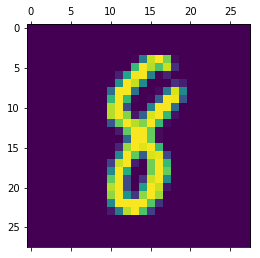

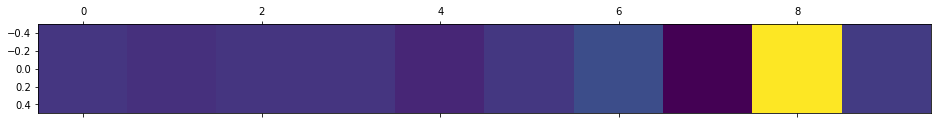

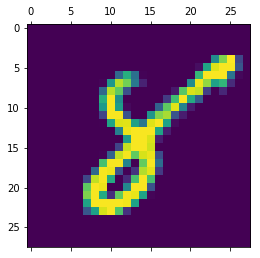

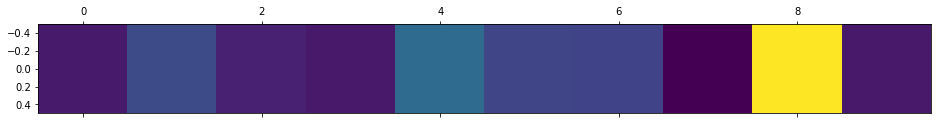

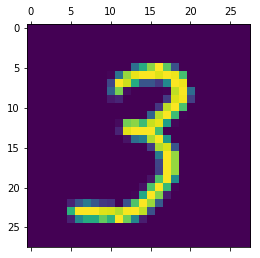

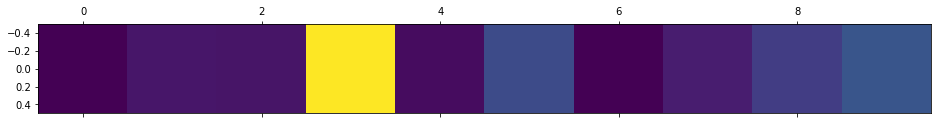

In [8]:
indices = random.sample(range(len(mnist.test.images)), 3)
for index in indices:
    image = mnist.test.images[index]
    plt.matshow(image.reshape((28, 28)))
    distribution = classify(image)
    plt.matshow(distribution**0.1)